# Analyse qualité des chants

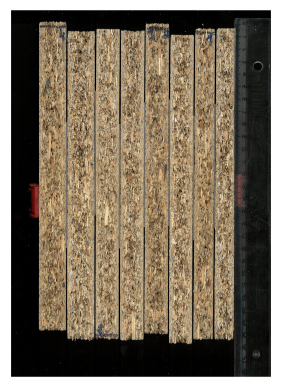

In [1]:
from tkinter import Tk, filedialog
from PIL import Image
import matplotlib.pyplot as plt
import io
import cv2
import numpy as np

# Ouvrir une boîte de dialogue pour sélectionner un fichier
Tk().withdraw()  # Cacher la fenêtre Tkinter
filename = filedialog.askopenfilename(title="Sélectionnez une image", filetypes=[("Images", "*.png;*.jpg;*.jpeg;*.bmp;*.tiff")])

# Vérifier si un fichier a été sélectionné
if filename:
    # Lire l'image avec PIL
    image = Image.open(filename)

    # Afficher l'image
    plt.imshow(image)
    plt.axis('off')  # Masquer les axes
    plt.show()
else:
    print("Aucun fichier sélectionné.")


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Ouvrir une image
image_path = "/home/audrey/Téléchargements/test.png"  # Remplace par le chemin de ton image
image = Image.open(image_path)

# Afficher l'image
plt.imshow(image)
plt.axis("off")  # Masquer les axes
plt.show()

## Analyse de l'image

Contour 1: Taux de noir sur total = 37.0 %


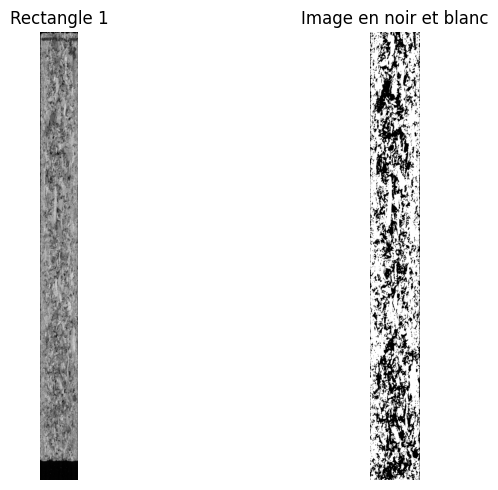

Contour 2: Taux de noir sur total = 31.58 %


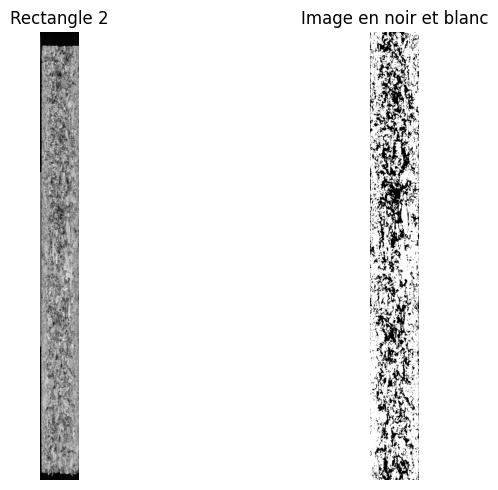

Contour 3: Taux de noir sur total = 25.96 %


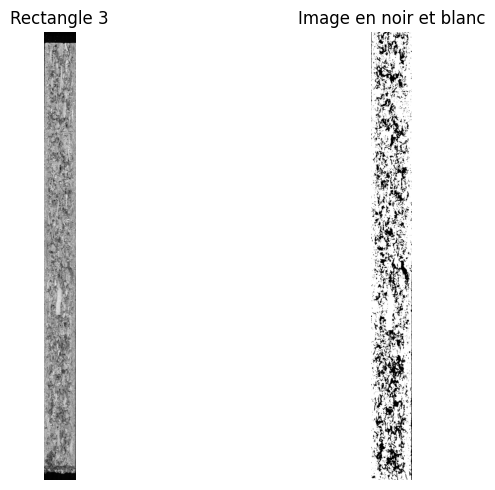

Contour 4: Taux de noir sur total = 29.37 %


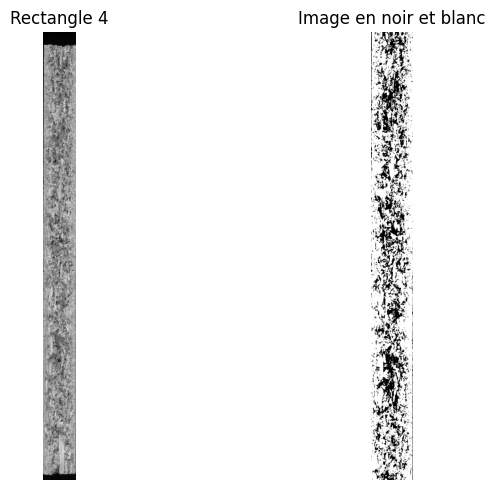

Contour 5: Taux de noir sur total = 37.34 %


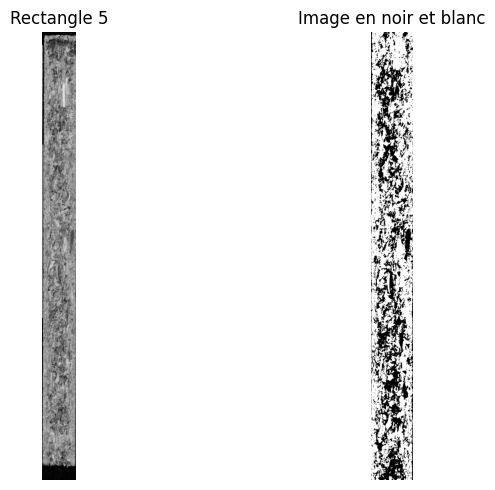

Contour 6: Taux de noir sur total = 29.66 %


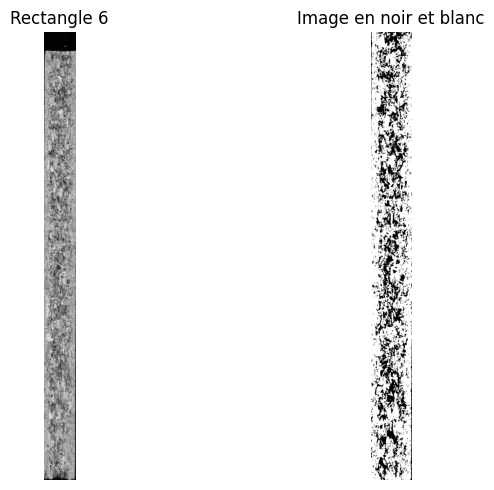

Contour 7: Taux de noir sur total = 34.85 %


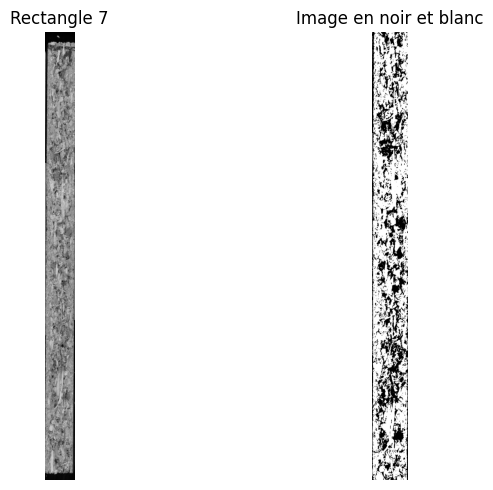

Contour 8: Taux de noir sur total = 36.71 %


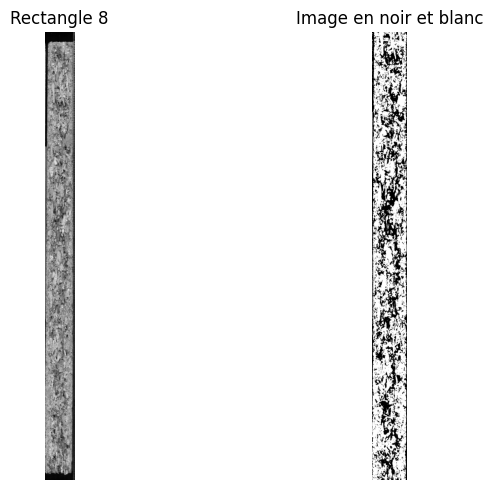

In [15]:

image_np = np.array(image)

# Convertir l'image en niveaux de gris
gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

#cropper l'image pour supprimer tout le noir autour
#seuil pour supprimer le bruit tout autour
gray2 = np.where(gray < 100 , 255, gray)

# Threshold the image to create a binary mask
_, thresh = cv2.threshold(gray2, 250, 255, cv2.THRESH_BINARY_INV)

# Find the contours of the non-white regions
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the bounding rectangle for the largest contour
x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))

# Crop the image
gray = gray[y:y+h, x:x+w]


# Appliquer un seuillage binaire
_, binary = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY_INV)

# Détecter les contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filtrer les contours pour ne garder que les lignes verticales
vertical_lines = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = h / float(w)
    if aspect_ratio > 10:  # Ajustez ce seuil selon vos besoins
        vertical_lines.append((x, y, w, h))

# Trier les lignes verticales par position x
vertical_lines.sort(key=lambda line: line[0])

# Isoler chaque rectangle entre les lignes verticales
rectangles = []
previous_x = 0

for line in vertical_lines:
    x, y, w, h = line
    if x > previous_x:  # Vérifier que la largeur est non nulle
        # Isoler la partie de l'image entre previous_x et x 
        rectangle = gray[:, previous_x:x]
        if rectangle.size > 1000000:
            rectangles.append(rectangle)
    previous_x = x + w

# Ajouter la dernière section de l'image
if previous_x < gray.shape[1]:  # Vérifier que la largeur est non nulle
    rectangle = gray[:, previous_x:]
    if rectangle.size > 1000000:
        rectangles.append(rectangle)


# Afficher les rectangles isolés
for i, rect in enumerate(rectangles):

    # Initialiser des listes pour stocker les indices des lignes et colonnes à conserver
    lignes_a_conserver = []
    colonnes_a_conserver = []

    # Seuil pour considérer un pixel comme "sombre"
    seuil_sombre = 50  # Vous pouvez ajuster ce seuil si nécessaire

    #Garde les lignes et colonnes sans trop de proportion noire (élimine les bords noirs)
    lignes_a_conserver = [k for k in range(rect.shape[0]) if np.sum(rect[k, :] < 50) / rect.shape[1] < 0.8]
    colonnes_a_conserver = [j for j in range(rect.shape[1]) if np.sum(rect[:, j] < 50) / rect.shape[0] < 0.3]
    
    # Créer une nouvelle image avec les lignes et colonnes à conserver
    image_filtre = rect[np.ix_(lignes_a_conserver, colonnes_a_conserver)]

    #supprime le haut et le bas pour enlever les écritures
    # Calculer la hauteur
    hauteur, largeur = image_filtre.shape[:2]
    # Recadrer l'image pour supprimer le 1/x supérieur et inférieur
    image_filtre = image_filtre[hauteur // 10:(hauteur - hauteur // 10), :]

    # Appliquer un seuillage binaire
    _, binary_image = cv2.threshold(image_filtre, 127, 255, cv2.THRESH_BINARY)

    # Calculer le taux de noir sur total
    total_pixels = binary_image.size
    black_pixels = np.sum(binary_image == 0)

    if total_pixels > 0:  # Eviter la division par zéro
        black_ratio = round((black_pixels / total_pixels)*100,2)
        print(f"Contour {i+1}: Taux de noir sur total = {black_ratio} %")

        # Créer une figure avec deux sous-graphiques côte à côte
    plt.figure(figsize=(10, 5))  # Ajustez la taille de la figure selon vos besoins

    # Afficher la première image
    plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, 1er subplot
    plt.imshow(cv2.cvtColor(rect, cv2.COLOR_BGR2RGB))
    plt.title(f'Rectangle {i+1}')
    plt.axis('off')

    # Afficher la deuxième image
    plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, 2ème subplot
    plt.imshow(binary_image, cmap='gray')
    plt.axis('off')  # Masquer les axes
    plt.title('Image en noir et blanc')

    # Afficher les images
    plt.tight_layout()  # Ajuster l'espacement entre les sous-graphiques
    plt.show()

